In [ ]:
import pandas as pd
import numpy as np
from bff_processor.data_tools import regex_select, get_files, make_df
from bff_processor.utils import time_func, hist2unc, linear, parabola 
from bff_processor.bff_meta import preselection, band_cut, isin, identity, band_cut2d
from bff_processor.plotting_utils import produce_bff_hists, boost_plot, boost_plot2d, unc_plot
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS)

In [2]:
import yaml
with open('bff_cut.yml', 'r') as f:
    param_values = yaml.load(f, yaml.SafeLoader)
param_values

{'popt_TMB_1': [0.005670138080420392, -27.29281866461732],
 'popt_TMB_2': [0.6093794937097095, -64.4041343060181],
 'popt_htlt_1': [-1.0026559611103478, 222.61050011298494],
 'popt_htlt_2': [-1.1557356800591116, 321.9988110349092],
 'popt_relmet_1': [-0.0009521985285842506, 0.5653313657969021],
 'popt_relmet_2': [-0.0008842778102153833, 0.5196790389687582]}

In [3]:
popt_relmet_1 = param_values['popt_relmet_1']
popt_relmet_2 = param_values['popt_relmet_2']
RelMET_ff1 = lambda x: band_cut2d('DiLepMass','RelMET_nom', high=popt_relmet_1)(isin('SR1_nom')(x))
RelMET_ff2 = lambda x: band_cut2d('DiLepMass','RelMET_nom', high=popt_relmet_2)(isin('SR2_nom')(x))

popt_htlt_1 = param_values['popt_htlt_1']
popt_htlt_2 = param_values['popt_htlt_2']
HTLT_ff1 = lambda x: band_cut2d('DiLepMass','HTLT_nom', high=popt_htlt_1)(RelMET_ff1)
HTLT_ff2 = lambda x: band_cut2d('DiLepMass','HTLT_nom', high=popt_htlt_2)(RelMET_ff2)

popt_TMB_1 = param_values['popt_TMB_1']
popt_TMB_2 = param_values['popt_TMB_2']
TMB_ff1 = lambda x: band_cut2d('DiLepMass','TMB_nom', low=popt_TMB_1)(HTLT_ff1)
TMB_ff2 = lambda x: band_cut2d('DiLepMass','TMB_nom', low=popt_TMB_2)(HTLT_ff2)

In [39]:
# get 2017 files
#era = 2016
era = 2018
file_re = regex_select(era)
file_dict = get_files(file_re)

In [40]:
#make df of background
backgrounds = file_dict['DY']+file_dict['TT']+file_dict['ST']+file_dict['VB']
background_df = preselection()(make_df(backgrounds))

In [41]:
#make df of signals
import re
bff_dict = {}
for fname in file_dict['BFF']:
    #print(fname)
    name = re.findall('_M_([0-9]+)_dbs(\d)p(\d+)', fname)[0]
    name = "{} {}.{}".format(*name)
    #print(name)
    if name not in bff_dict:
        bff_dict[name] = []
    bff_dict[name].append(fname)
for name, item in bff_dict.items():
    if len(item) != 1: continue
    print(item)
    bff_dict[name] = preselection()(make_df(item))
bff_samples = ['125 0.04', '200 0.04','350 0.04','500 0.04']
bff_dict.keys()

['data/tw_2018_BFFZprimeToMuMu_M_300_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_175_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_500_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_200_dbs1p0.csv']
['data/tw_2018_BFFZprimeToMuMu_M_350_dbs0p5.csv']
['data/tw_2018_BFFZprimeToMuMu_M_350_dbs1p0.csv']
['data/tw_2018_BFFZprimeToMuMu_M_125_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_500_dbs0p5.csv']
['data/tw_2018_BFFZprimeToMuMu_M_150_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_500_dbs1p0.csv']
['data/tw_2018_BFFZprimeToMuMu_M_250_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_200_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_350_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_450_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_400_dbs0p04.csv']
['data/tw_2018_BFFZprimeToMuMu_M_200_dbs0p5.csv']


dict_keys(['300 0.04', '175 0.04', '500 0.04', '200 1.0', '350 0.5', '350 1.0', '125 0.04', '500 0.5', '150 0.04', '500 1.0', '250 0.04', '200 0.04', '350 0.04', '450 0.04', '400 0.04', '200 0.5'])

In [42]:
columns = [
    ['DiLepMass', [139,105,800]],
    ['TMB_nom',       [80,0, 800]],
    ['HTLT_nom',      [100,-500,500]],
    ['RelMET_nom',    [100, 0,1]]
]

In [43]:
def significance(sig,bck):
    return sig/(sig+bck+1e-12)**.5

In [44]:
#optimize RelMET cut:
def column_1d_sig(sig_df, bck_df, mass_band=1, filter_func=lambda x: x):
    #select for region
    _sig_df = filter_func(sig_df)
    _bck_df =  filter_func(bck_df)
    mean, std = sig_df['DiLepMass'].mean(), sig_df['DiLepMass'].std()
    widht = std*mass_band
    #mass band cut
    _sig_df = band_cut('DiLepMass',mean-widht, mean+widht)(_sig_df)
    _bck_df = band_cut('DiLepMass',mean-widht, mean+widht)(_bck_df)
    bck_1d_hist, bck_2d_hist = produce_bff_hists(_bck_df, "", columns, weight='Weight')
    sig_1d_hist, sig_2d_hist = produce_bff_hists(_sig_df, "", columns, weight='Weight')
    return bck_1d_hist, sig_1d_hist, bck_2d_hist, sig_2d_hist

In [45]:
def calc_sig_cut(s,b, direction=1):
    from itertools import accumulate
    s,b = np.array(list(accumulate(s[::direction])))[::direction], np.array(list(accumulate(b[::direction])))[::direction]
    return significance(s,b)

In [46]:
from scipy.stats import norm
def map_signf(value, signf, centers):
    diff = np.abs(centers - value)
    delta  = (centers[1] - centers[0])
    weight = norm.pdf(diff, loc=0, scale=delta*1)
    wval = np.dot(signf,weight)/np.sum(weight+1e-12)
    return wval.nominal_value


In [47]:
def linear_sig(masses, sigs, centers, *popt):
    signfs = []
    for m, sig in zip(masses,sigs):
        cut_val = linear(m,*popt)
        signf = map_signf(cut_val, sig, centers)
        signfs.append(signf+1e-12)
    return np.dot(-np.array(signfs), np.power(masses, 0))

In [48]:
from scipy.optimize import curve_fit, minimize
from bff_processor.utils import vunc2nom, vunc2std
import uncertainties

In [49]:
def plot_opt_sig(column,bff_dict, background_df, p0, fit=False, filter_func=lambda x: x, postfix="",direction=1):
    fig,ax = plt.subplots(2,4, figsize=[30,20])
    fit_x = []
    fit_y = []
    fit_y_unc = []
    sigs = []
    masses = []
    for j, m in enumerate(bff_samples):
        mass = int(re.findall('([0-9]+)',m)[0])
        bck_1d_hist, sig_1d_hist, bck_2d_hist, sig_2d_hist = column_1d_sig(bff_dict[m], background_df, mass_band=2,filter_func=filter_func)
        
        top_ax = ax[0,j]
        boost_plot(top_ax, bck_1d_hist[column] ,label='background')
        boost_plot(top_ax, sig_1d_hist[column] ,label='Signal {} GeV'.format(m))
        top_ax.set_ylabel(column)
        top_ax.set_xlabel('Counts')
        top_ax.legend()
        
        s,b = hist2unc(sig_1d_hist[column]), hist2unc(bck_1d_hist[column])
        signf_val = calc_sig_cut(s,b, direction=direction)
        
        centers = sig_1d_hist[column].axes[0].centers
        unc_plot(ax[1][j], signf_val,centers, zorder=1)
        peak_index = np.argmax(signf_val)
        peak_center = centers[peak_index]
        peak_height = signf_val[peak_index]
        
        sigs.append(signf_val)
        masses.append(mass)
        
        if fit:
                lims = (peak_index-5,peak_index+5)
                c_band = centers[lims[0]:lims[1]]
                nom_band = vunc2nom(signf_val)[lims[0]:lims[1]]
                std_band = vunc2std(signf_val)[lims[0]:lims[1]]
                popt, pcov = curve_fit(parabola,c_band, nom_band, sigma=std_band, absolute_sigma=True)
                corr_values = uncertainties.correlated_values(popt,pcov)
                ax[1][j].plot(c_band,parabola(c_band,*popt), zorder=2)
                peak_center = popt[0]
                peak_height = popt[1]
            
        #uncertainty of center
        upper_limit = vunc2nom(signf_val)+vunc2std(signf_val)
        in_range = centers[upper_limit > peak_height]
        sigma_range = np.asarray((in_range[0], in_range[-1]))
        unc = np.max(np.abs(sigma_range-peak_center))
        fit_x.append(mass)
        fit_y.append(peak_center)
        fit_y_unc.append(unc)
            
        ax[1][j].set_title("max: {:.2f}+/-{:.2f}".format(peak_center, unc), zorder=2)
        
    fit_func = lambda popt: linear_sig(masses, sigs, centers, *popt)

    
    popt = p0
    masses = np.array(masses)
    cut_points = linear(masses, *popt)
    for j, (m, c, s) in enumerate(zip(masses, cut_points, sigs)):
        sig_at_cut = map_signf(c, s, centers)
        print(sig_at_cut, c)
        #ax[1][j].plot([c,c], [0,sig_at_cut], zorder=1)
        ax[1][j].scatter([c], [sig_at_cut], zorder=1,s=150, c='red', marker=(5, 1), label='cut location')
        ax[1][j].legend()
    fig.savefig("output/sig_tuning/{}_{}_{}.pdf".format(era, column, postfix), transparent=False)
    return popt
    
    #return popt
        #break

In [50]:
popt_relmet_1 = param_values['popt_relmet_1']
popt_relmet_2 = param_values['popt_relmet_2']
RelMET_ff1 = lambda x: band_cut2d('DiLepMass','RelMET_nom', high=popt_relmet_1)(isin('SR1_nom')(x))
RelMET_ff2 = lambda x: band_cut2d('DiLepMass','RelMET_nom', high=popt_relmet_2)(isin('SR2_nom')(x))

popt_htlt_1 = param_values['popt_htlt_1']
popt_htlt_2 = param_values['popt_htlt_2']
HTLT_ff1 = lambda x: band_cut2d('DiLepMass','HTLT_nom', high=popt_htlt_1)(RelMET_ff1(x))
HTLT_ff2 = lambda x: band_cut2d('DiLepMass','HTLT_nom', high=popt_htlt_2)(RelMET_ff2(x))

popt_TMB_1 = param_values['popt_TMB_1']
popt_TMB_2 = param_values['popt_TMB_2']
TMB_ff1 = lambda x: band_cut2d('DiLepMass','TMB_nom', low=popt_TMB_1)(HTLT_ff1(x))
TMB_ff2 = lambda x: band_cut2d('DiLepMass','TMB_nom', low=popt_TMB_2)(HTLT_ff2(x))

33.93821553846498 0.4463065497238708
26.621158055100427 0.37489166008005204
7.8080202107523595 0.2320618807924144
3.6153549861775343 0.08923210150477684
17.063032449706853 0.4091443126918353
9.247452123881285 0.34282347692568155
2.884550621345749 0.21018180539337405
1.3915770196446329 0.07754013386106656


[-0.0008842778102153833, 0.5196790389687582]

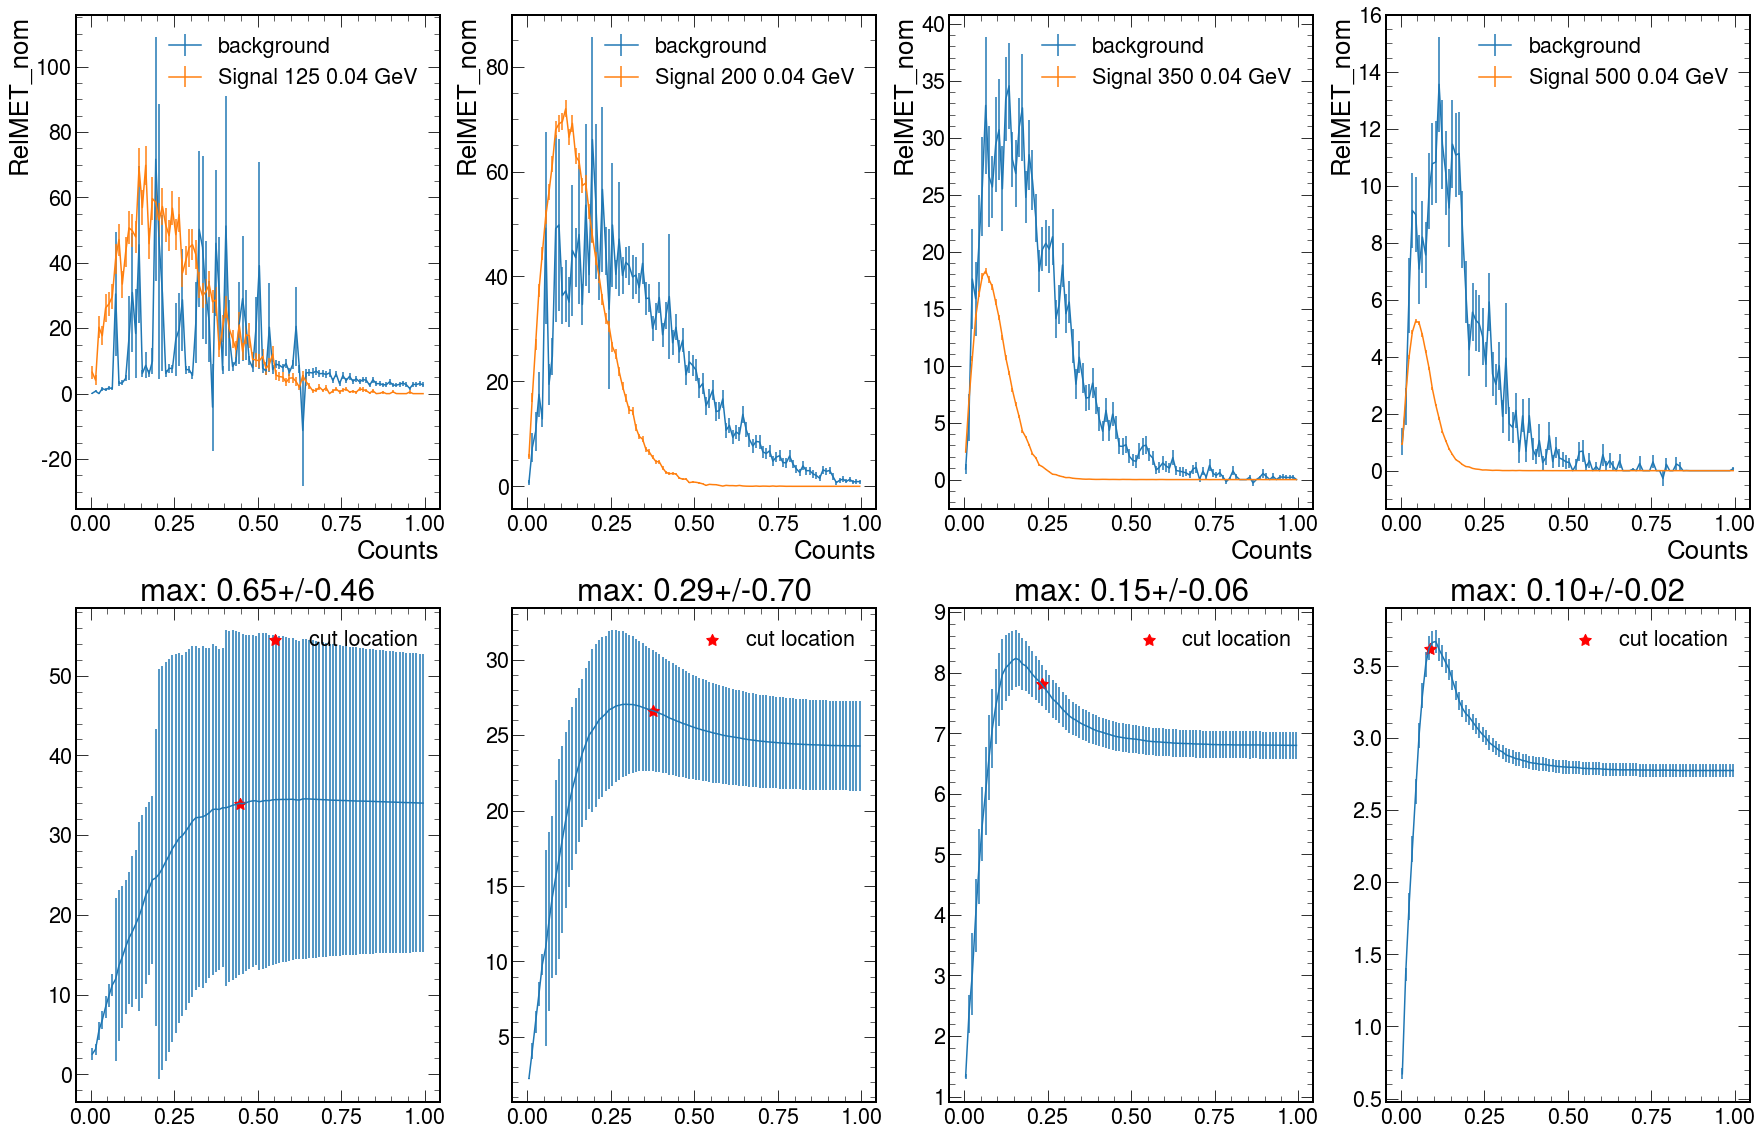

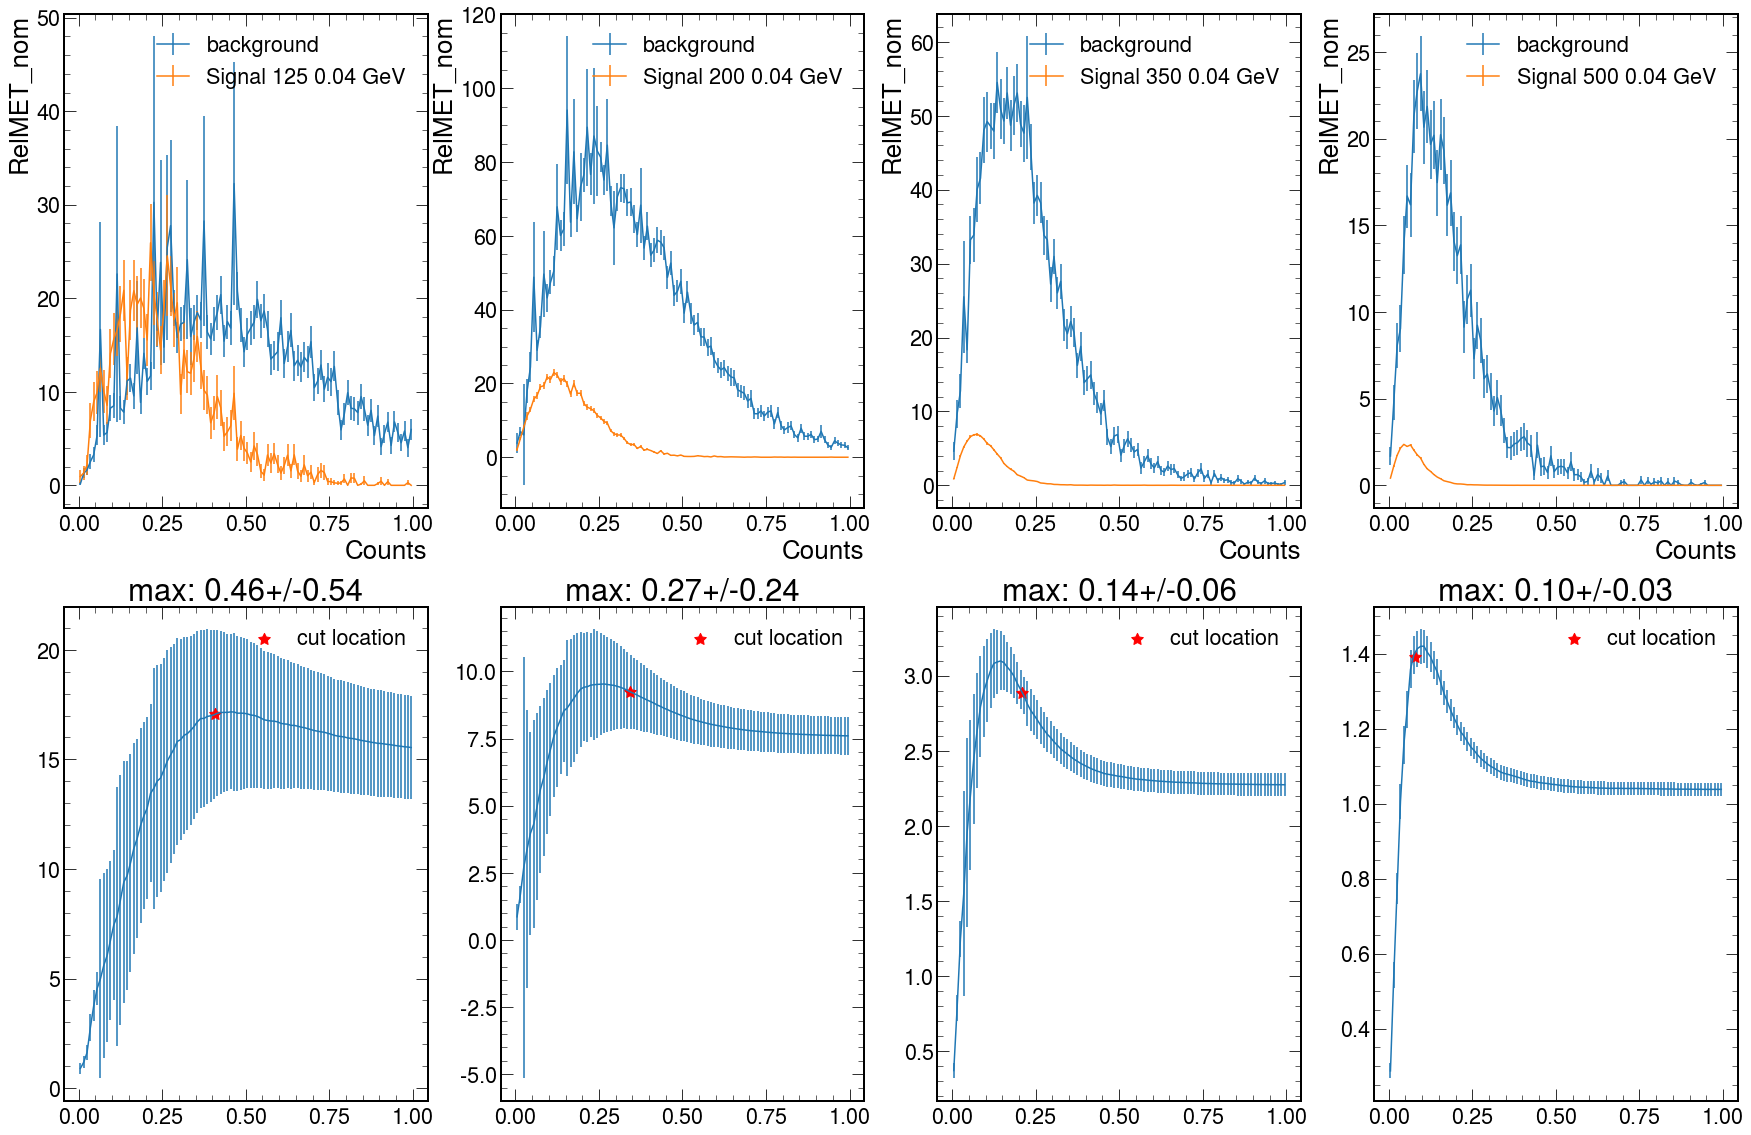

In [51]:
plot_opt_sig('RelMET_nom',bff_dict, background_df, popt_relmet_1, filter_func=isin('SR1_nom'), postfix='_one_jet')
plot_opt_sig('RelMET_nom',bff_dict, background_df, popt_relmet_2, filter_func=isin('SR2_nom'), postfix='_two_jet')

33.91155761119042 97.27850497419146
26.628102260346466 22.079307890915373
7.832647159753616 -128.31908627563678
3.7404513193732822 -278.71748044218896
16.960483244760294 177.53185102752022
9.329755070801635 90.85167502308684
2.9677642248106806 -82.50867698577991
1.5519859694597256 -255.86902899464667


[-1.1557356800591116, 321.9988110349092]

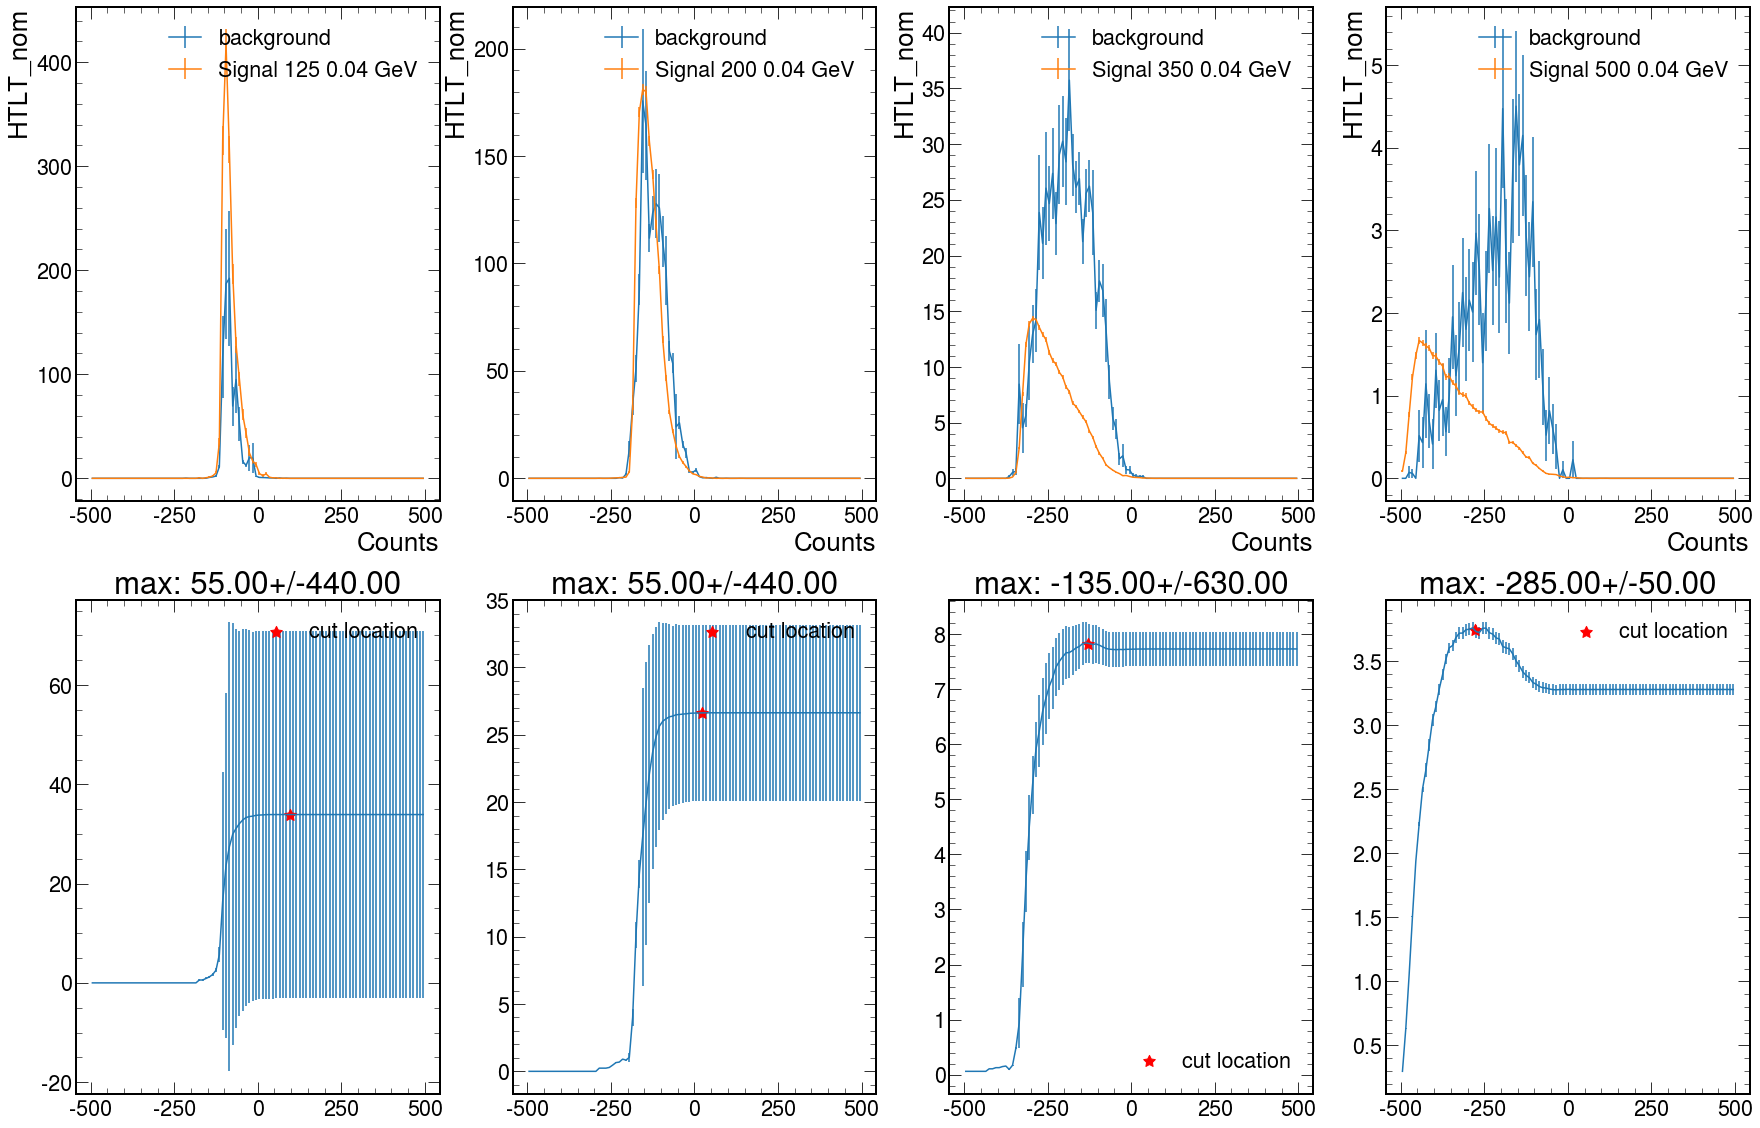

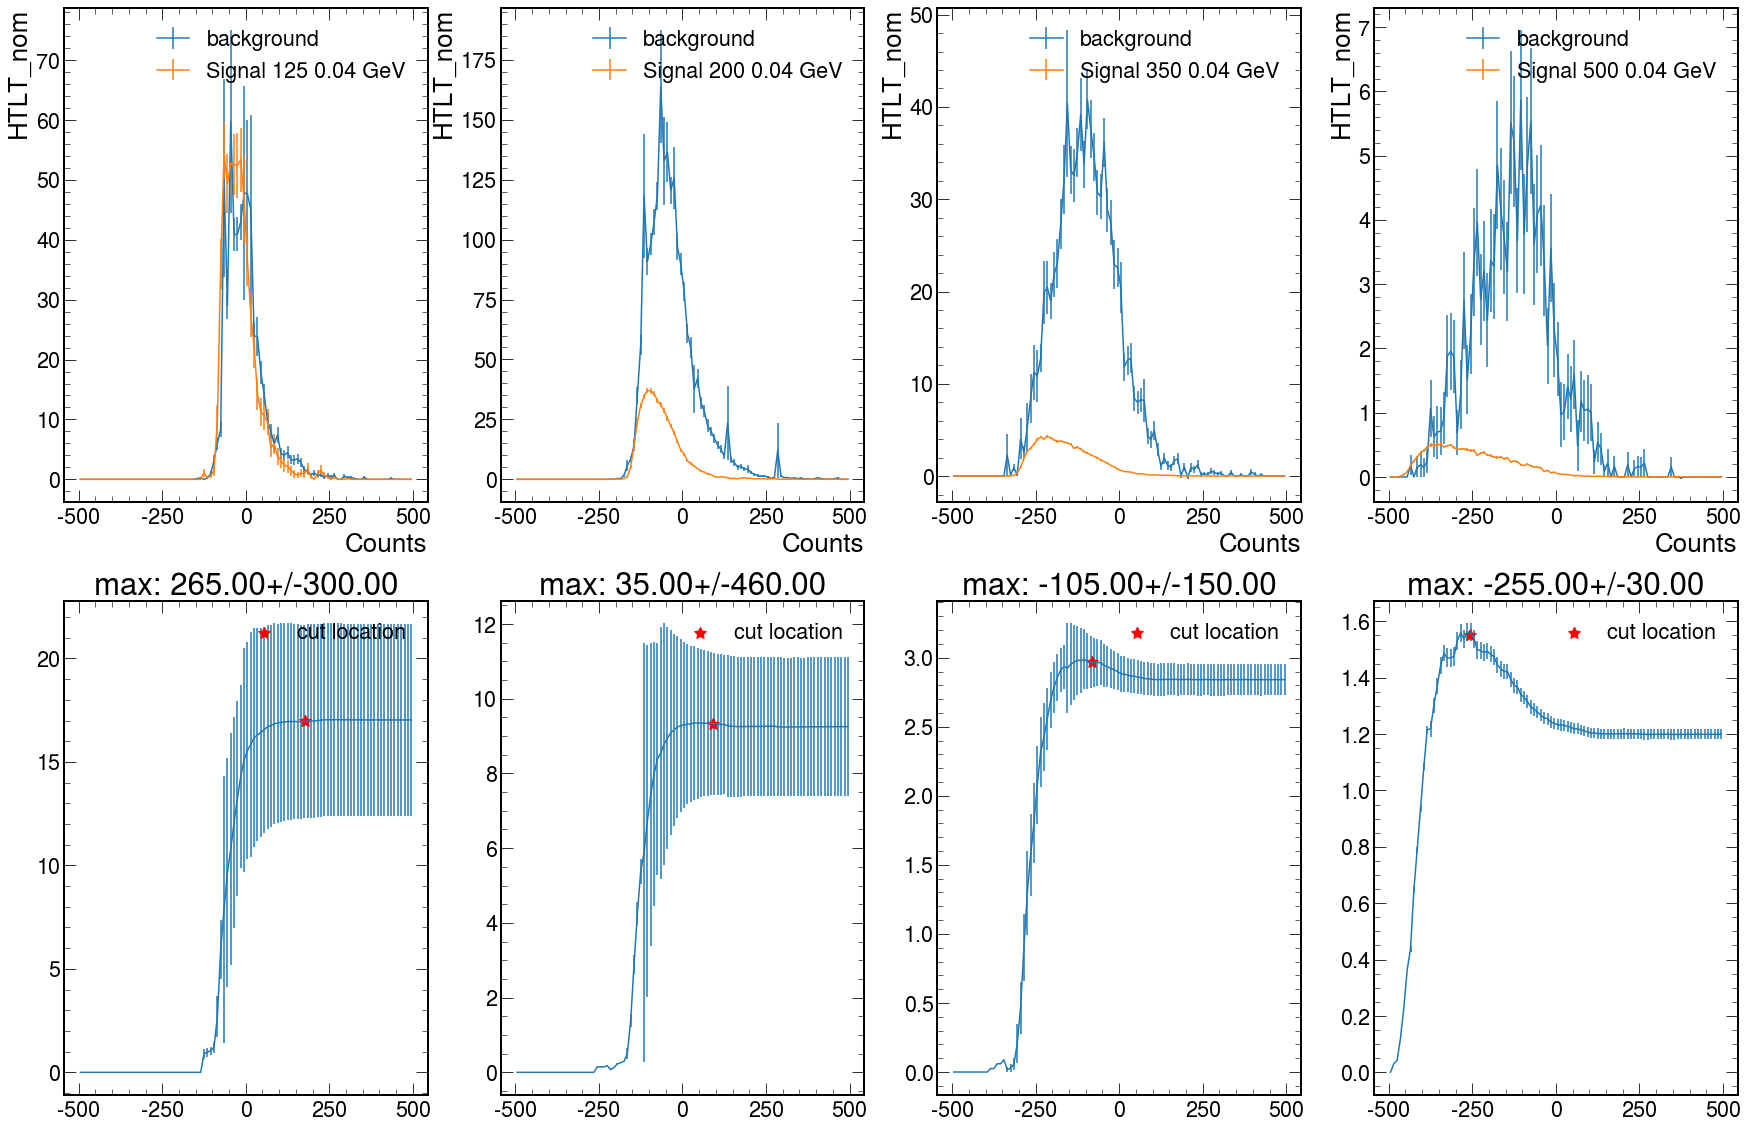

In [52]:
plot_opt_sig('HTLT_nom',bff_dict, background_df, popt_htlt_1, filter_func=RelMET_ff1, postfix='_one_jet')
plot_opt_sig('HTLT_nom',bff_dict, background_df, popt_htlt_2, filter_func=RelMET_ff2, postfix='_two_jet')

33.911543245061836 -26.58405140456477
26.628562633635816 -26.158791048533242
7.711337708226692 -25.308270336470184
3.499810062046277 -24.457749624407125
16.946013293520174 11.768302407695586
9.258241746860373 57.4717644359238
3.3417947906028864 148.8786884923802
1.3243447289382695 240.28561254883664


[0.6093794937097095, -64.4041343060181]

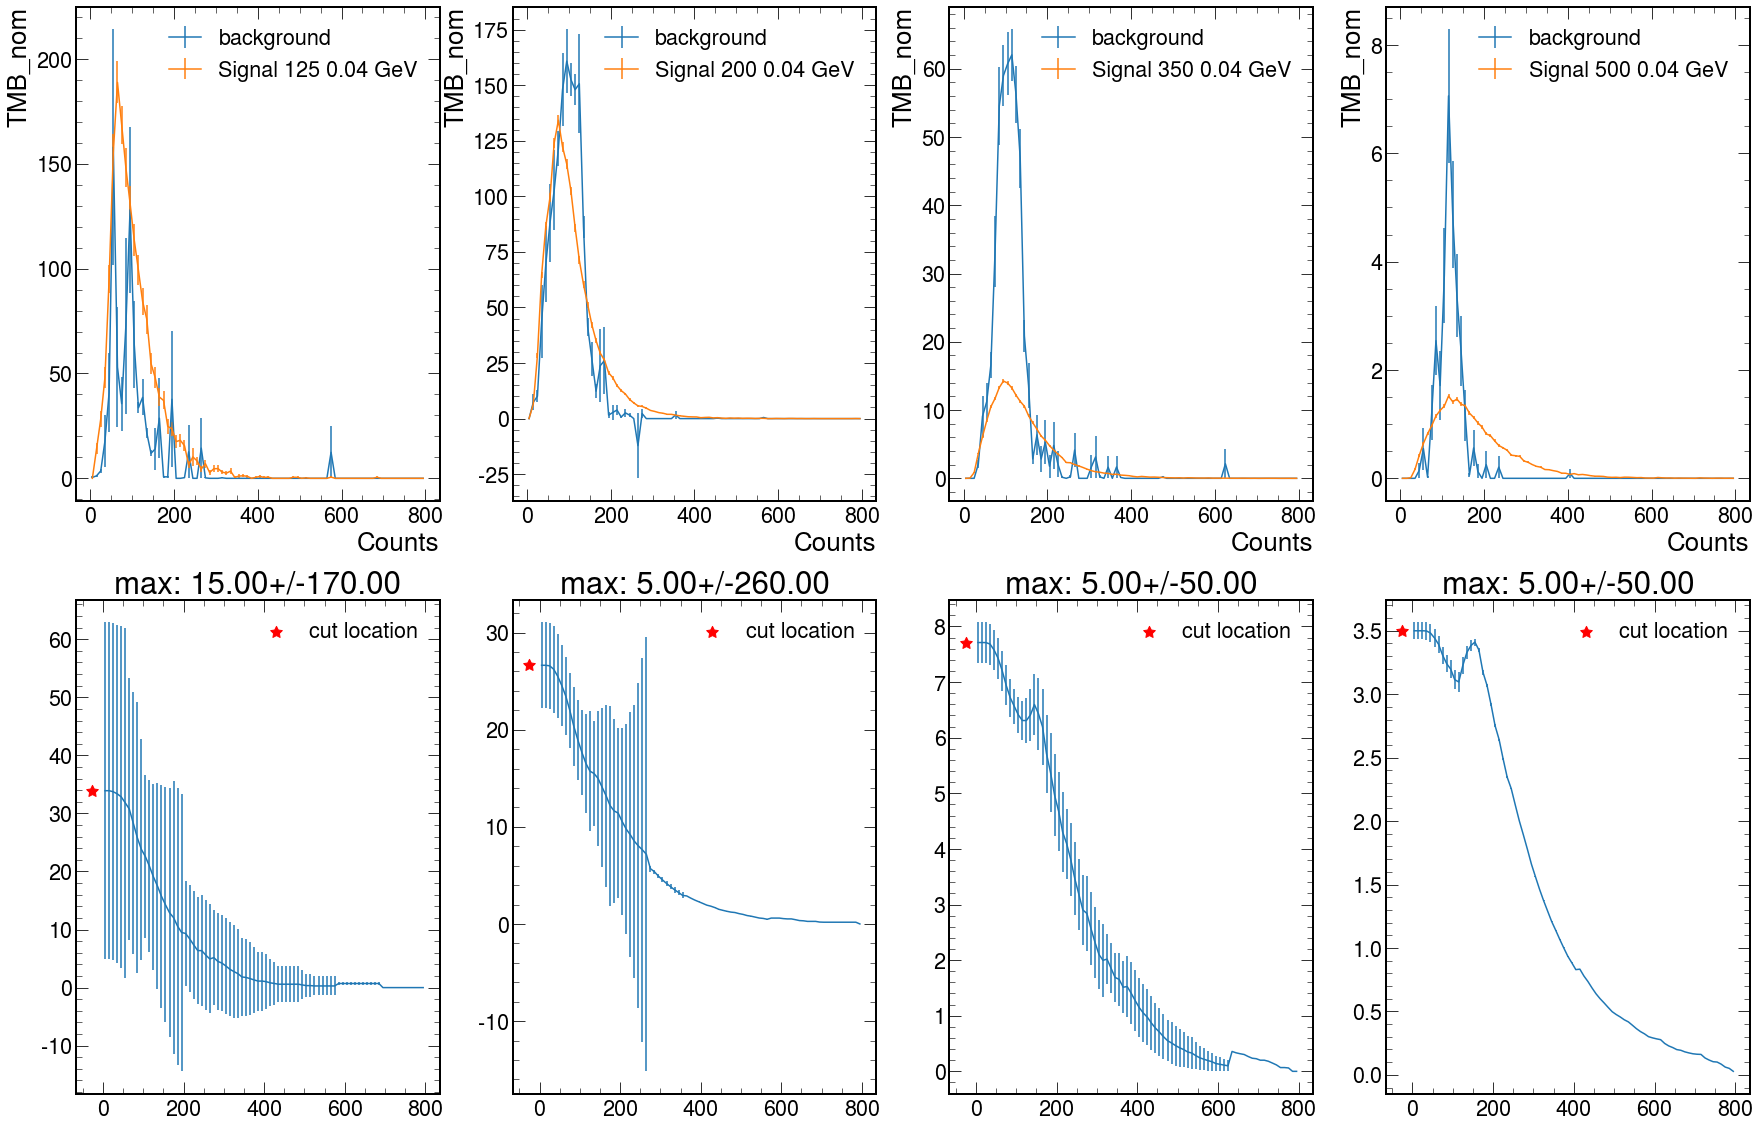

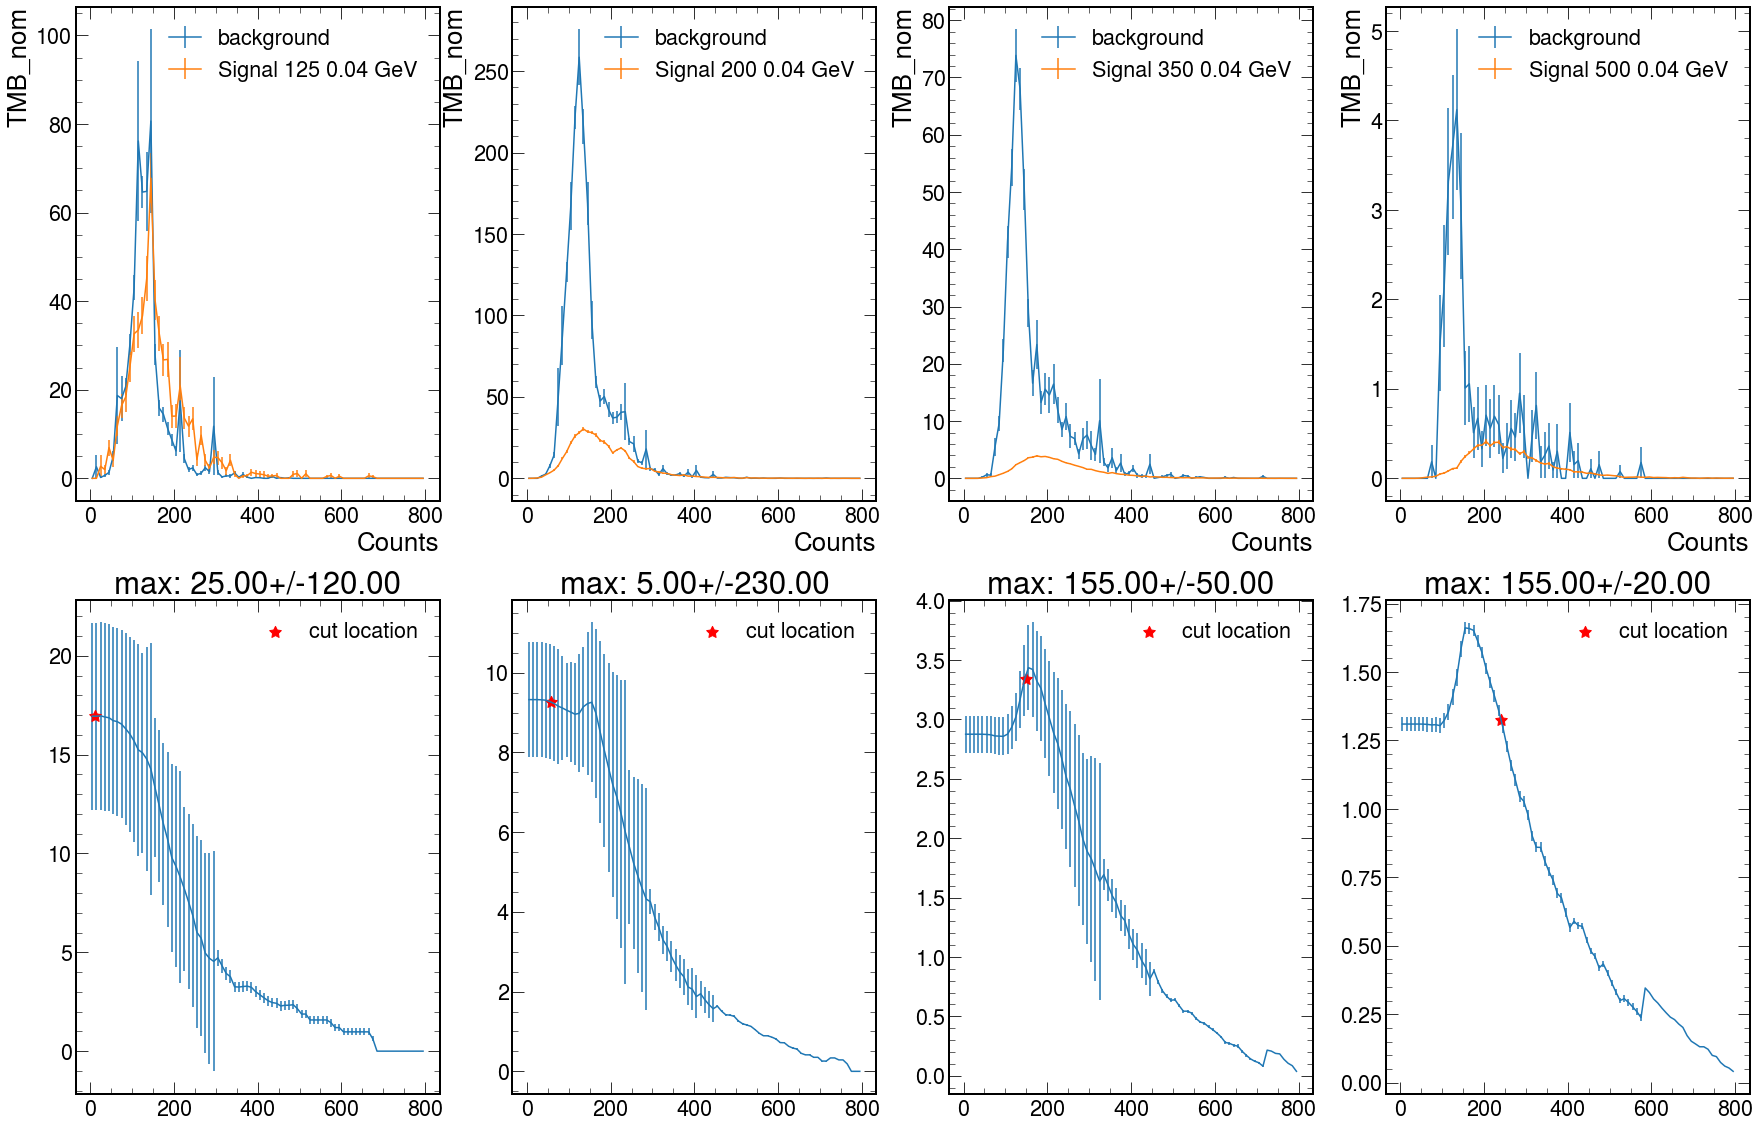

In [53]:
plot_opt_sig('TMB_nom',bff_dict, background_df, popt_TMB_1, direction=-1, filter_func=HTLT_ff1, postfix='_one_jet')
plot_opt_sig('TMB_nom',bff_dict, background_df, popt_TMB_2, direction=-1,  filter_func=HTLT_ff2, postfix='_two_jet')